**Import Depencencies**

In [93]:
# %pip install pandas as pd
# %pip install numpy as np
# %pip install scikit-learn
# %pip install matplotlib.pyplot as plt
# %pip install seaborn

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import re


**Create DataFrame**

In [95]:
#ADD FUNCTIONS

import difflib


# IS MAJOR CITY FUNCTION - SHIPMENTS DF
def isMajorCity(city):
    majorCities = ["new york", "nyc", "ny", "chicago", "san francisco", "san fran", "los angeles", "la"]
    
    closest_match = difflib.get_close_matches(city, majorCities)
    if closest_match and closest_match[0] == city.lower():
         return True

    return False

# MAJOR CITY MULTIPLIER AMOUNT - DF
def majorCityMultiplierAmount(isMajorCity, oldCalculatorAmount):
     if isMajorCity == True:
          result = (oldCalculatorAmount * 0.25) / 2
          return result
     
     else:
          return 0


Import CSVs

In [96]:
# SHIPPING DASHBOARD CSV
shipments_df = pd.read_csv("shipments_2023.csv")
# shipments_df['is major city'] = shipments_df['HP City'].str.lower().apply(isMajorCity)

# GAS PRICE AVERAGES CSV
monthly_gas_averages = pd.read_csv("./gas_averages - U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices (2) (1).csv")
# monthly_gas_averages.rename(columns={'Month': 'Month_gas'}, inplace=True)
# monthly_gas_averages['MonthDateTime'] = pd.to_datetime(monthly_gas_averages['Month'], format='%Y-%mm')

# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')

# ADJUST PROJECT DATE TO MATCH MONTHLY GAS AVG & MERGE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)
# shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month', suffixes=('_shipments', '_gas_averages'))
shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month')
# shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month_gas')
shipments_df = shipments_df.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon': 'avg_gas_price'})

print(shipments_df)


       AF               Date Created                            Created By   
0    4365  2022-05-12 14:19:54 -0500             Project Management Intern  \
1    4503  2022-11-20 23:20:52 -0500             Project Management Intern   
2    4491  2022-11-07 11:49:36 -0500                          Amanda Weber   
3    4475  2022-10-11 13:13:12 -0500                          Amanda Weber   
4    4492  2022-11-07 15:15:28 -0500                          Amanda Weber   
..    ...                        ...                                   ...   
183  4730  2023-10-12 20:25:31 +0000                                public   
184  4677  2023-08-11 21:06:07 +0000  amanda@feedingchildreneverywhere.com   
185  4680  2023-08-11 21:06:10 +0000  amanda@feedingchildreneverywhere.com   
186  4679  2023-08-11 21:06:09 +0000  amanda@feedingchildreneverywhere.com   
187  4723  2023-10-05 20:00:44 +0000                                public   

                  Date Updated                            Updat

Create Data Frame - LTL DATA ONLY

In [97]:
# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')


# MERGE NATIONAL GAS PRICE AVERAGES WITH PROJECT DATE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)


# OUTBOUND
outbound_columns = ['Load In Date & Time', 'Outbound # of Pallets', 'Outbound Total Weight (in lbs)', 'Outbound Type of Truck', 'Price Quoted for Outbound', 'One Way Distance To/From Warehouse', 'avg_gas_price', 'HP City']
outbound_df = shipments_df[outbound_columns].copy()
outbound_df = outbound_df[outbound_df['Outbound Type of Truck'] == 'LTL']


# INBOUND
inbound_columns = ['Load Out Date & Time', 'Return # of Pallets', 'Return Total Weight', 'Return Type of Truck', 'Price Quoted for Return', 'One Way Distance To/From Warehouse', 'avg_gas_price', 'HP City']
inbound_df = shipments_df[inbound_columns].copy()
inbound_df = inbound_df[inbound_df['Return Type of Truck'] == 'LTL']


# CLEAN UP DATES IN OUTBOUND & INBOUND DF
date_pattern = r'(\d{1,2}/\d{1,2}/\d{2,4})'

date_time_extracted_loadOut = outbound_df['Load In Date - Scrubbed'] = pd.to_datetime(outbound_df['Load In Date & Time'].str.extract(date_pattern)[0])
outbound_df['Load In Date - Scrubbed'] = pd.to_datetime(date_time_extracted_loadOut, errors='coerce')
outbound_df['Load In Date - Scrubbed'] = outbound_df['Load In Date - Scrubbed'].dt.strftime('%Y-%m-%d')

date_time_extracted_loadIn = inbound_df['Load Out Date - Scrubbed'] = pd.to_datetime(inbound_df['Load Out Date & Time'].str.extract(date_pattern)[0])
inbound_df['Load Out Date - Scrubbed'] = pd.to_datetime(date_time_extracted_loadIn, errors='coerce')
inbound_df['Load Out Date - Scrubbed'] = inbound_df['Load Out Date - Scrubbed'].dt.strftime('%Y-%m-%d')


#CREATE WORKING DF
df = pd.DataFrame()
df['pallets'] = pd.concat([outbound_df['Outbound # of Pallets'], inbound_df['Return # of Pallets']], ignore_index=True)
df['weight'] = pd.concat([outbound_df['Outbound Total Weight (in lbs)'], inbound_df['Return Total Weight']], ignore_index=True)
df['distance'] = pd.concat([outbound_df['One Way Distance To/From Warehouse'], inbound_df['One Way Distance To/From Warehouse']], ignore_index=True)
df['avg_gas_price'] = pd.concat([outbound_df['avg_gas_price'], inbound_df['avg_gas_price']], ignore_index=True)
df['quote'] = pd.concat([outbound_df['Price Quoted for Outbound'], inbound_df['Price Quoted for Return']], ignore_index=True)
df['city'] = pd.concat([outbound_df['HP City'], inbound_df['HP City']], ignore_index=True)
# df['shipment on a weekend'] = 


# CLEAN UP COLUMNS
df['weight'] = df['weight'].str.replace(',', '').str.replace(' lbs', '').astype(int)
df['distance'] = df['distance'].str.replace(',', '').str.replace(' miles', '').astype(float)
df['quote'] = df['quote'].str.replace("$", '').str.replace(',', '').astype(float)
df['pallets'] = df['pallets'].astype(float)
df = df.dropna(axis=0)


# OLD CALCULATOR 
df["Old Calculator"] = (((df["distance"] * .114 + 105) * df["pallets"]) + 150 + 22.5)
df['Old Calculator - %15 & %5 multiplier'] = ((df['Old Calculator'] + (df['Old Calculator'] * 0.15)) * 1.05) 
df['is major city'] = df['city'].str.lower().apply(isMajorCity)
df['Old Calculator - With Buffs'] = np.where(df['is major city'] == True, df['Old Calculator - %15 & %5 multiplier'] * 1.25, df['Old Calculator - %15 & %5 multiplier'])

# CLEAN UP DF
df.drop(columns=['Old Calculator - %15 & %5 multiplier', 'city'], inplace=True)


# SHOW RESULTS
# print(df.iloc[:, 0:5])
print(df)

     pallets  weight  distance  avg_gas_price    quote  Old Calculator   
0        3.0    4100      89.0          3.445   510.00         517.938  \
1        3.0    4000     936.0          3.445   925.17         807.612   
2        3.0    4100     747.0          3.445   921.33         742.974   
3        6.0    8800     799.0          3.445  1656.31        1349.016   
4        4.0    5000     960.0          3.445  1198.72        1030.260   
..       ...     ...       ...            ...      ...             ...   
157      3.0    3000     747.0          3.257   941.33         742.974   
158      2.0    1800     907.0          3.257   653.73         589.296   
159      2.0    1000    2200.0          3.257   693.87         884.100   
160      4.0    2800    1832.0          3.257  1299.09        1427.892   
161      3.0    2600     955.0          3.257   984.56         814.110   

     is major city  Old Calculator - With Buffs  
0            False                   625.410135  
1          

C:\Users\patri\AppData\Local\Temp\ipykernel_7940\1657698991.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time_extracted_loadOut = outbound_df['Load In Date - Scrubbed'] = pd.to_datetime(outbound_df['Load In Date & Time'].str.extract(date_pattern)[0])
C:\Users\patri\AppData\Local\Temp\ipykernel_7940\1657698991.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time_extracted_loadIn = inbound_df['Load Out Date - Scrubbed'] = pd.to_datetime(inbound_df['Load Out Date & Time'].str.extract(date_pattern)[0])


**Train Model**

In [98]:
# INDEPENDENT VARIABLES
X = df[['pallets', 'weight', 'distance', 'avg_gas_price']]  # 'is major city'

# DEPENDENT VARIABLE
y = df['quote']

# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

# TRAINING MODEL
regressor = LinearRegression()
regressor.fit(X_train,y_train)

# VALIDATING MODEL
y_pred = regressor.predict(X_test)


Comparing Actual vs Predicted data points

In [99]:
results = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print(results.head())

      Actual    Predicted
7    1078.34  1022.358245
40   1224.49  1083.200980
96    541.24   698.871817
45   1800.00  1774.764899
111   653.16   791.357533


**Graph Results**

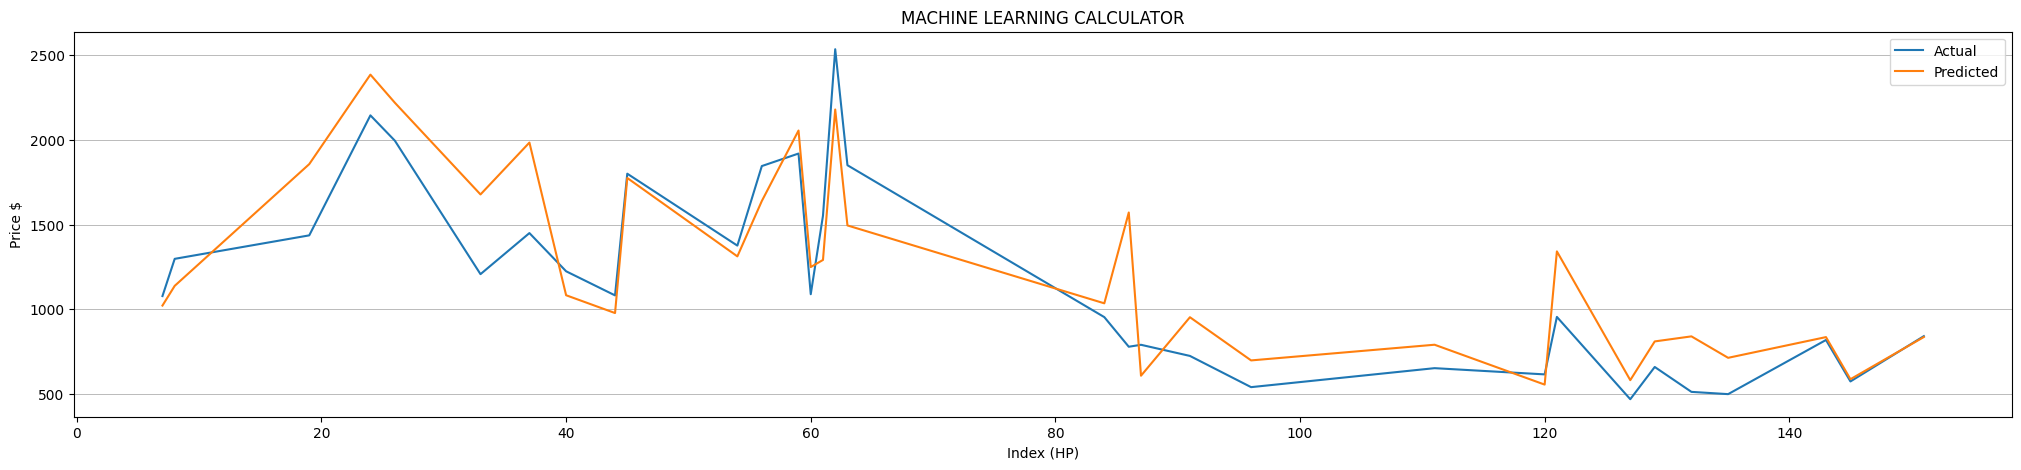

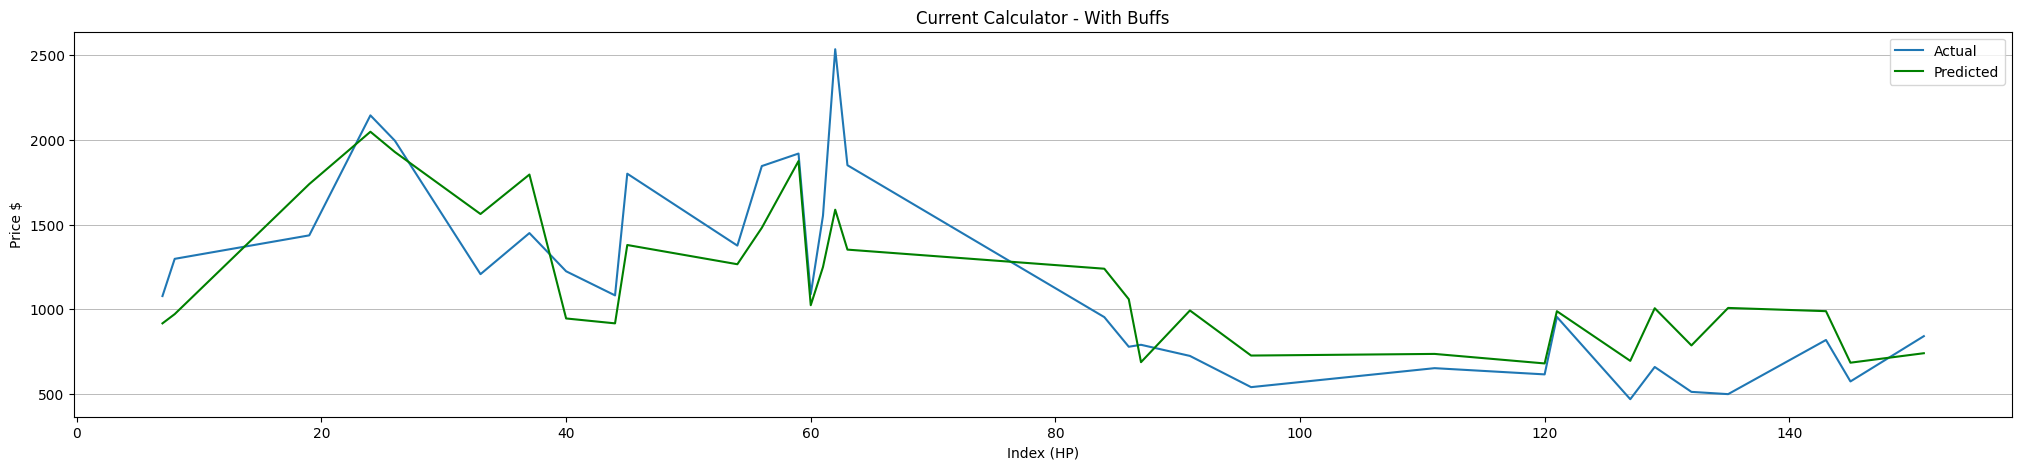

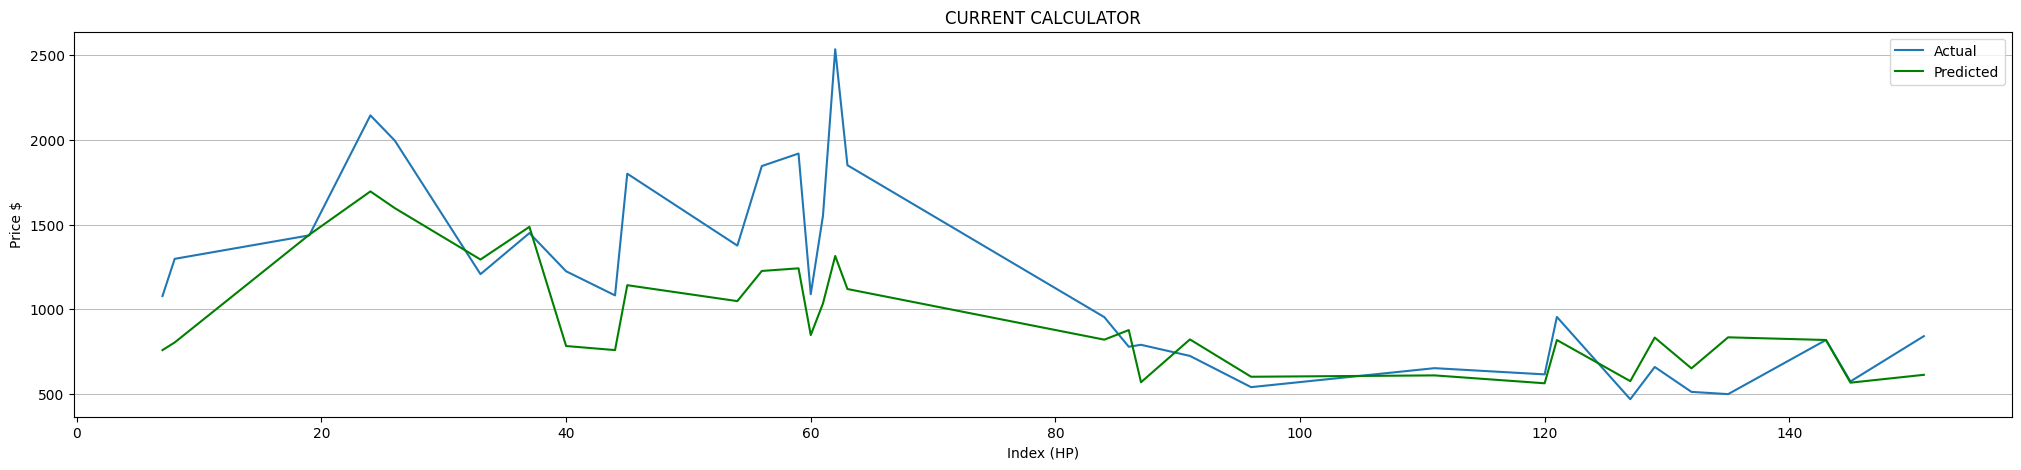

In [100]:
results['Old Calculator'] = df['Old Calculator']
results['Old Calculator - With Buffs'] = df['Old Calculator - With Buffs']

results.sort_index(inplace=True)

# MACHINE LEARNING CALCULATOR
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['Actual'], label='Actual', marker='')
plt.plot(results.index, results['Predicted'], label='Predicted', marker='')

plt.xlabel('Index (HP)')
plt.ylabel('Price $')
plt.title('MACHINE LEARNING CALCULATOR')
plt.legend()
plt.grid(axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.75)
plt.show()

# CURRENT CALCULATOR - WITH BUFFS
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['Actual'], label='Actual', marker='')
plt.plot(results.index, results['Old Calculator - With Buffs'], label='Predicted', marker='', color='green')

plt.xlabel('Index (HP)')
plt.ylabel('Price $')
plt.title('Current Calculator - With Buffs')
plt.legend()
plt.grid(axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.75)
plt.show()

# CURRENT CALCULATOR
plt.figure(figsize=(25, 5))
plt.plot(results.index, results['Actual'], label='Actual', marker='')
plt.plot(results.index, results['Old Calculator'], label='Predicted', marker='', color='green')

plt.xlabel('Index (HP)')
plt.ylabel('Price $')
plt.title('CURRENT CALCULATOR')
plt.legend()
plt.grid(axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.75)
plt.show()



**Metrics & Coefficients**

In [84]:
ml = '(ML):      '
old = '(CURRENT): '
sep = """
------------------
"""
# HEADER
print("\n2023 - LTL SHIPMENTS ONLY")
print(sep)

# TOTAL ERROR
total_error_ML = sum(results['Predicted']) - sum(results['Actual'])
total_error_OLD = sum(df['Old Calculator']) - sum(df['quote'])
print("TOTAL ERROR: ")
print(f"{ml} {total_error_ML:.2f}")
print(f"{old} {total_error_OLD:.2f}")
print("(CURRENT - WITH BUFFS): ", f"{sum(df['Old Calculator - With Buffs']) - sum(df['quote']):.2f}")
print(sep)

# MEAN ABSOLUTE ERROR
print("MEAN ABSOLUTE ERROR: ")
print(f"{ml} {metrics.mean_absolute_error(results['Actual'], results['Predicted']):.2f}")
print(f"{old} {metrics.mean_absolute_error(df['quote'], df['Old Calculator']):.2f}")
print(f"(CURRENT - WITH BUFFS): {metrics.mean_absolute_error(df['quote'], df['Old Calculator - With Buffs']):.2f}")
print(sep)

# COEFFICIENTS
coefficients = regressor.coef_
variable_names = X.columns
print('COEFFICIENTS:\n')
print(ml)
for variable, coefficient in zip(variable_names, coefficients):
    print(f"{variable}: {coefficient:.2f}")

print('\n')
print(old, '\ndistance: 0.114')
print(sep)

# X INTERCEPT
print("X INTERCEPT: ")
print(f"{ml} {regressor.intercept_:.2f}")
print(old, '150')


2023 - LTL SHIPMENTS ONLY

------------------

TOTAL ERROR: 
(ML):       2827.36
(CURRENT):  -43580.17
(CURRENT - WITH BUFFS):  -9305.27

------------------

MEAN ABSOLUTE ERROR: 
(ML):       211.79
(CURRENT):  316.06
(CURRENT - WITH BUFFS): 244.12

------------------

COEFFICIENTS:

(ML):      
pallets: 113.54
weight: 0.11
distance: 0.71
avg_gas_price: -52.74
is major city: 38.99


(CURRENT):  
distance: 0.114

------------------

X INTERCEPT: 
(ML):       -153.13
(CURRENT):  150


Best Fit Line Graphs

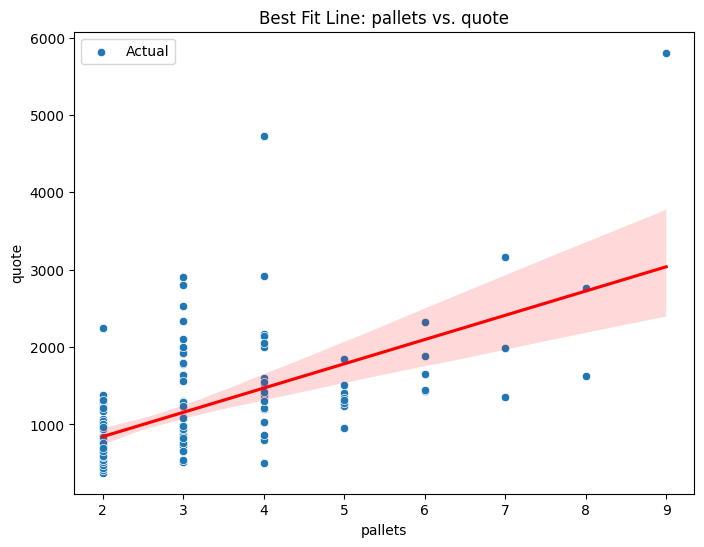

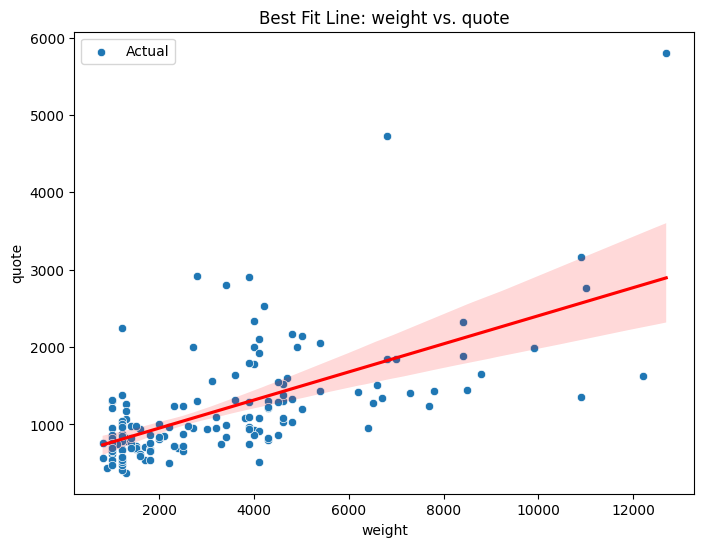

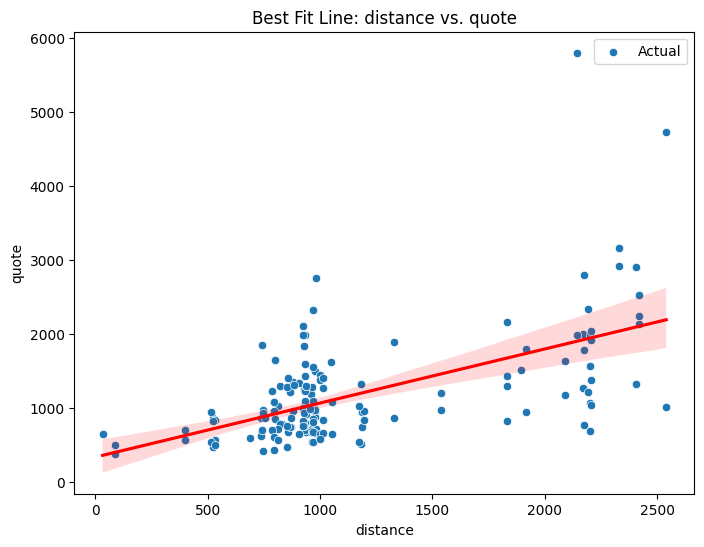

In [68]:
y_pred_graphs = regressor.predict(X)

for feature in X.columns:

    # REMOVE GAS PRICE CHART.. DOESNT MAKE SENSE TO ME
    if feature != 'avg_gas_price':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X[feature], y=y, label="Actual")
        
        # BEST FIT LINE
        sns.regplot(x=X[feature], y=y, line_kws={'color':'red'}, scatter=False)
        plt.title(f"Best Fit Line: {feature} vs. {y.name}")

        # LINEAR REGRESSION
        # sns.lineplot(x=X[feature], y=y_pred_graphs, color='red', label="Linear Regression")
        # plt.title(f"Linear Regression: {feature} vs. {y.name}")

        plt.xlabel(feature)
        plt.ylabel(y.name)
        plt.legend()
        plt.show()

RESULTS TO CSV

In [69]:
# INSERT NEW SHIPPING FORMULA RESULTS INTO 
df['ML Calculator Results'] = ((df['pallets'] * regressor.coef_[0]) + (df['weight'] * regressor.coef_[1]) + (df['distance'] * regressor.coef_[2]) + (df['avg_gas_price'] * regressor.coef_[3])) + regressor.intercept_

# TOTAL ERROR 
totalErrorML =  sum(df['ML Calculator Results']) - sum(df['quote'])
totalErrorCurrent = sum(df['Old Calculator']) - sum(df['quote'])


# PREP DF FOR CSV

df.drop(columns=['pallets', 'weight', 'distance', 'avg_gas_price'], inplace=True)
print(df)
df.to_csv("results.csv")

       quote  Old Calculator  Old Calculator - With Buffs   
0     510.00         517.938                   625.410135  \
1     925.17         807.612                   975.191490   
2     921.33         742.974                   897.141105   
3    1656.31        1349.016                  1628.936820   
4    1198.72        1030.260                  1244.038950   
..       ...             ...                          ...   
157   941.33         742.974                   897.141105   
158   653.73         589.296                   711.574920   
159   693.87         884.100                  1067.550750   
160  1299.09        1427.892                  1724.179590   
161   984.56         814.110                   983.037825   

     ML Calculator Results  
0               525.283013  
1              1119.170986  
2               995.213453  
3              1888.676859  
4              1359.292559  
..                     ...  
157             884.911862  
158             754.154434  
159   